## Problem Statement
Singapore Sign Language (SgSL) is used by the deaf community in Singapore and all over the world, Sign language has been developed to suit local contexes and has been used for many years. Unfortunately, Sign Language still faces a lack of recognition and awareness in many parts of the world and in Singapore too. There is also a general lack of interpreters for Sign Language. In order to bridge the gap in communication between users and non-users of Sign Language, promote awareness of Sign Language and the Deaf community, and encourage citizens to learn Sign Language, this project aims to develop a real-time SgSL translator using computer vision and neural networks (LSTM) where users can sign in front of a camera and the translation in english will appear on the screen.

## Background

Singapore Sign Language (SgSL) is the native sign language used in Singapore and was influenced by Shanghainese Sign Language, American Sign Language, Signing Exact English and other locally developed signs. SgSL is just one of the few ways that people with hearing loss communicate. Some may also use speech and listning to communicate, such as using lip-reading, or oral-based methods that amplifies the individual's residual hearing through assistive devices such as hearing aids or cochlear implants ([*source*](https://sadeaf.org.sg/about-us/about-sadeaf/)).

Sign Language has it's own grammar and linguistic structure that is different from that of spoken languages. Contrary to common belief, it is not a visual representation of spoken language and does not relate grammatically to any spoken language.
([*source*](https://sadeaf.org.sg/about-deafness/about-sign-language/)).
Hence this project was named 'Singapore Sign Language Translation' and not '..Interpretation' or '..Detection'. 

Project outline:
- Collect keypoints from landmarks as data for training the model
    - Data was collected using local webcam 
    - for each action, 30 videos were collected, each video containing 30 frames, each frame containing an array of landmarks detected in the frame.
- Data for general greeting actions and all 26 letters of the alphabet were collected, resulting in a total of 960 videos that formed the entire dataset.
- Stacked LSTM modelling was used as the detections were made in sequential order. 
- The epoch loss and accuracy was tracked in real-time using Tensorboard
- The model was optimised by changing the number of layers, number of neurons in the layers, as well as batch size
- The final LSTM model had an accuracy of 0.83. 

## Further Information

SgSL was recently adopted officially in the Deaf education in signing-designated mainstream schools in 2018 although it has existed in the deaf community way before that. 
SgSL has 5 main parameters (similar to speech sounds in spoken language): handshape, orientation, location, movement, and non-manual markers (i.e. features that are beyond the hand such as facial expressions, mouthing, head/body movement). This project aims to cover 4 out of 5 of the parameters in SgSL - Handshape, Orientation, Location and Movement ([*source*](https://www.sgslsignbank.org.sg/sgsl/language-parameters)).

Signs used in the data collection and model training were taken from the SgSL Sign Bank as well as a deaf-led enterprise, ExtraOrdinary Horizons ([*source*](https://www.eohorizons.com/)).

### Install and Import Dependencies

In [94]:
#!pip install opencv-python
#!pip install mediapipe

In [88]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time 
import mediapipe as mp 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard #monitors accuracy etc while training
from flask import Flask, Response # For wed deployment

### Create functions for landmark detections


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities to draw keypoints
mp_drawing_styles = mp.solutions.dng_styles # Drawing styles

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB for detection using mediapipe
    image.flags.writeable = False # Set to unwriteable to save memory
    results = model.process(image) # Predict
    image.flags.writeable = True # Image can be written now
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert RGB back to BGR for *visuals*
    return image, results

In [4]:
def styled_landmarks(image, results):
    # Pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                            ) 
    # Left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                            ) 
    # Right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                            )   

### Extract and Collect Keypoints

- Pose landmarks: (x, y, z, visibility) will always return landmarks but visibility value in each landmark may vary
- Left hand landmarks: (x, y, z) if no value is returned/error is returned -> nothing is detected
- Right hand landmarks: (x, y, z) if no value is returned/error is returned -> nothing is detected <br />
<br />
- pose (x, y, z, visibility) has 33 landmarks -> 33 * 4 values for each landmark
- left hand and right hand (x, y, z) have 21 landmarks -> 21 * 3 values for each landmark
- face (x, y, z) has 468 landmarks -> 468 * 3 values for each landmark

For data collection, each action will have 30 videos, each video is 30 frames in length and each frame collects. data will be saved using numpy.save (np.save). Each frame contains an array of values of landmarks detected.

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lefthand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    righthand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)     
    combined_array = np.concatenate([pose, lefthand, righthand]) 
    return combined_array 

### Collect Keypoints for Training
Initially, only 20 sequences (videos) were collected for each Sign, however the model results were sub-par due to the lack of data. Hence the number of sequences was increased to 30.

Also, face landmarks was also initially collected. However, the model showed difficulties in differentiating between similar Signs and it was hypothesised that the face landmarks were contributing to the lack of differentiation. Mediapipe's Facemesh detects 468 landmarks on the face and this initially contributed to majority of each sequence collected. After removing the face landmarks from the data collection, the model performance improved and misclassificaiton was greatly reduced.

In [6]:
DATA_PATH = os.path.join('capstone_data')

# Seperate actions into sets for easier collection
greeting_actions = np.array(['Hello','bye','good',"I'm sorry",'welcome','thank you'])
alphabet_actions = np.array(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

# Combine all actions to put into modelling
all_actions = np.array(['Hello','bye','good',"I'm sorry",'welcome','thank you','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

no_sequences = 30 # 30 sequences for each action 
sequence_length = 30 # Videos are 30 frames in length
start_folder = 30

In [ ]:
def create_folders(action_set):
    for action in action_set:
        for sequence in range(1, no_sequences+1):
            try: 
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            except:
                pass

In [ ]:
create_folders(greeting_actions)

Collecting Videos

In [ ]:
def data_collection(action_set):
    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # NEW LOOP
        # Loop through actions
        for action in action_set:
            
            # Loop through sequences aka videos
            for sequence in range(1, no_sequences+1):
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    styled_landmarks(image, results)

                    # NEW Apply wait logic
                    if frame_num == 1: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)

                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # stop opencv
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
                        
        #CLOSE THE WINDOWS
        cap.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        cv2.waitKey(1)
        cv2.waitKey(1)
        cv2.waitKey(1)

In [ ]:
data_collection(greeting_actions)

### Data Pre-processing
Create a label map for all sign actions, perform one-hot encoding for y labels and train test split

In [95]:
label_map = {label:num for num, label in enumerate(all_actions)}

In [98]:
sequences, labels = [], []
for action in all_actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [97]:
label_map

{'Hello': 0,
 'bye': 1,
 'good': 2,
 "I'm sorry": 3,
 'welcome': 4,
 'thank you': 5,
 'a': 6,
 'b': 7,
 'c': 8,
 'd': 9,
 'e': 10,
 'f': 11,
 'g': 12,
 'h': 13,
 'i': 14,
 'j': 15,
 'k': 16,
 'l': 17,
 'm': 18,
 'n': 19,
 'o': 20,
 'p': 21,
 'q': 22,
 'r': 23,
 's': 24,
 't': 25,
 'u': 26,
 'v': 27,
 'w': 28,
 'x': 29,
 'y': 30,
 'z': 31}

In [10]:
np.array(sequences).shape

(960, 30, 258)

960 videos, 30 frames each, with 258 different keypoints

In [11]:
X = np.array(sequences)
X.shape

(960, 30, 258)

In [12]:
#one-hot encode labels
y = to_categorical(labels).astype(int)

In [13]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [14]:
X_train.shape

(864, 30, 258)

In [15]:
X_test.shape

(96, 30, 258)

In [16]:
y_train.shape

(864, 32)

In [17]:
y_test.shape

(96, 32)

### LSTM modelling
Although the original LSTM model contains a single hidden LSTM layer followed by a standard feedforward output layer, Stacked LSTMs were used in this project, which is an extension to the original LSTM model that has multiple hidden LSTM layers where each layer contains multiple memory cells.

Stacked LSTMs were used due to the sequential nature of the prediction. The previous LSTM layer provides a sequence output to the next LSTM layer.

#### Model 1: Baseline model, a 3-layer LSTM model 

In [20]:
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(30,258))) #each video is 30 frames w 258 keypts
model_1.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so return_seq needs to be FALSE
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(all_actions.shape[0], activation='softmax'))


2021-12-13 14:29:54.154038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [21]:
model_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
history_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=len(X_train), callbacks=[tb_callback])

Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 3.5646 - categorical_accuracy: 0.0336 - val_loss: 3.4839 - val_categorical_accuracy: 0.0104
Epoch 2/300
1/1 [==============================] - 0s 445ms/step - loss: 3.4789 - categorical_accuracy: 0.0255 - val_loss: 3.4645 - val_categorical_accuracy: 0.0312
Epoch 3/300
1/1 [==============================] - 0s 439ms/step - loss: 3.4685 - categorical_accuracy: 0.0509 - val_loss: 3.4579 - val_categorical_accuracy: 0.0208
Epoch 4/300
1/1 [==============================] - 0s 435ms/step - loss: 3.4635 - categorical_accuracy: 0.0347 - val_loss: 3.4578 - val_categorical_accuracy: 0.0312
Epoch 5/300
1/1 [==============================] - 0s 434ms/step - loss: 3.4613 - categorical_accuracy: 0.0243 - val_loss: 3.4568 - val_categorical_accuracy: 0.0521
Epoch 6/300
1/1 [==============================] - 0s 443ms/step - loss: 3.4583 - categorical_accuracy: 0.0289 - val_loss: 3.4547 - val_categorical_accuracy: 0.0417
Epoch 7/300
1

1/1 [==============================] - 0s 403ms/step - loss: 2.5413 - categorical_accuracy: 0.2049 - val_loss: 2.5853 - val_categorical_accuracy: 0.1979
Epoch 51/300
1/1 [==============================] - 0s 406ms/step - loss: 2.5333 - categorical_accuracy: 0.2130 - val_loss: 2.6329 - val_categorical_accuracy: 0.1667
Epoch 52/300
1/1 [==============================] - 0s 402ms/step - loss: 2.5738 - categorical_accuracy: 0.1910 - val_loss: 2.4929 - val_categorical_accuracy: 0.2500
Epoch 53/300
1/1 [==============================] - 0s 406ms/step - loss: 2.4419 - categorical_accuracy: 0.2407 - val_loss: 2.6198 - val_categorical_accuracy: 0.1979
Epoch 54/300
1/1 [==============================] - 0s 403ms/step - loss: 2.5518 - categorical_accuracy: 0.2257 - val_loss: 2.5293 - val_categorical_accuracy: 0.2083
Epoch 55/300
1/1 [==============================] - 0s 412ms/step - loss: 2.4622 - categorical_accuracy: 0.2442 - val_loss: 2.5371 - val_categorical_accuracy: 0.2083
Epoch 56/300
1/1 

1/1 [==============================] - 0s 401ms/step - loss: 1.4554 - categorical_accuracy: 0.5266 - val_loss: 1.6670 - val_categorical_accuracy: 0.4062
Epoch 100/300
1/1 [==============================] - 0s 405ms/step - loss: 1.4768 - categorical_accuracy: 0.5139 - val_loss: 1.6677 - val_categorical_accuracy: 0.4271
Epoch 101/300
1/1 [==============================] - 0s 402ms/step - loss: 1.4330 - categorical_accuracy: 0.5197 - val_loss: 1.6015 - val_categorical_accuracy: 0.4479
Epoch 102/300
1/1 [==============================] - 0s 392ms/step - loss: 1.4015 - categorical_accuracy: 0.5324 - val_loss: 1.6026 - val_categorical_accuracy: 0.4167
Epoch 103/300
1/1 [==============================] - 0s 406ms/step - loss: 1.4010 - categorical_accuracy: 0.5475 - val_loss: 1.5751 - val_categorical_accuracy: 0.4688
Epoch 104/300
1/1 [==============================] - 0s 396ms/step - loss: 1.4078 - categorical_accuracy: 0.5347 - val_loss: 1.7053 - val_categorical_accuracy: 0.3854
Epoch 105/30

1/1 [==============================] - 0s 398ms/step - loss: 1.0486 - categorical_accuracy: 0.6632 - val_loss: 1.3970 - val_categorical_accuracy: 0.5417
Epoch 149/300
1/1 [==============================] - 0s 399ms/step - loss: 1.0367 - categorical_accuracy: 0.6447 - val_loss: 1.4084 - val_categorical_accuracy: 0.5417
Epoch 150/300
1/1 [==============================] - 0s 399ms/step - loss: 1.0930 - categorical_accuracy: 0.6343 - val_loss: 1.5976 - val_categorical_accuracy: 0.5104
Epoch 151/300
1/1 [==============================] - 0s 399ms/step - loss: 1.1177 - categorical_accuracy: 0.6134 - val_loss: 1.4298 - val_categorical_accuracy: 0.5417
Epoch 152/300
1/1 [==============================] - 0s 407ms/step - loss: 1.0085 - categorical_accuracy: 0.6597 - val_loss: 1.3672 - val_categorical_accuracy: 0.5729
Epoch 153/300
1/1 [==============================] - 0s 396ms/step - loss: 0.9543 - categorical_accuracy: 0.6759 - val_loss: 1.4153 - val_categorical_accuracy: 0.5729
Epoch 154/30

1/1 [==============================] - 0s 398ms/step - loss: 0.9246 - categorical_accuracy: 0.6875 - val_loss: 1.2960 - val_categorical_accuracy: 0.5729
Epoch 198/300
1/1 [==============================] - 0s 411ms/step - loss: 0.9237 - categorical_accuracy: 0.6910 - val_loss: 1.2453 - val_categorical_accuracy: 0.6146
Epoch 199/300
1/1 [==============================] - 0s 396ms/step - loss: 0.8299 - categorical_accuracy: 0.7350 - val_loss: 1.3123 - val_categorical_accuracy: 0.6042
Epoch 200/300
1/1 [==============================] - 0s 400ms/step - loss: 0.8414 - categorical_accuracy: 0.7280 - val_loss: 1.2833 - val_categorical_accuracy: 0.5938
Epoch 201/300
1/1 [==============================] - 0s 397ms/step - loss: 0.8579 - categorical_accuracy: 0.7083 - val_loss: 1.2880 - val_categorical_accuracy: 0.6458
Epoch 202/300
1/1 [==============================] - 0s 401ms/step - loss: 0.8175 - categorical_accuracy: 0.7269 - val_loss: 1.3242 - val_categorical_accuracy: 0.6042
Epoch 203/30

1/1 [==============================] - 0s 403ms/step - loss: 1.7250 - categorical_accuracy: 0.4502 - val_loss: 2.0501 - val_categorical_accuracy: 0.3750
Epoch 247/300
1/1 [==============================] - 0s 409ms/step - loss: 1.7869 - categorical_accuracy: 0.4468 - val_loss: 1.9625 - val_categorical_accuracy: 0.3750
Epoch 248/300
1/1 [==============================] - 0s 399ms/step - loss: 1.7443 - categorical_accuracy: 0.4606 - val_loss: 1.8545 - val_categorical_accuracy: 0.4479
Epoch 249/300
1/1 [==============================] - 1s 538ms/step - loss: 1.6661 - categorical_accuracy: 0.4803 - val_loss: 1.8157 - val_categorical_accuracy: 0.4271
Epoch 250/300
1/1 [==============================] - 1s 587ms/step - loss: 1.6450 - categorical_accuracy: 0.5162 - val_loss: 1.7317 - val_categorical_accuracy: 0.4583
Epoch 251/300
1/1 [==============================] - 0s 398ms/step - loss: 1.6061 - categorical_accuracy: 0.5394 - val_loss: 1.7143 - val_categorical_accuracy: 0.4583
Epoch 252/30

1/1 [==============================] - 0s 407ms/step - loss: 1.2000 - categorical_accuracy: 0.5972 - val_loss: 3.3658 - val_categorical_accuracy: 0.3750
Epoch 296/300
1/1 [==============================] - 0s 401ms/step - loss: 2.1855 - categorical_accuracy: 0.5231 - val_loss: 3.5588 - val_categorical_accuracy: 0.3542
Epoch 297/300
1/1 [==============================] - 0s 395ms/step - loss: 2.2252 - categorical_accuracy: 0.4803 - val_loss: 3.2358 - val_categorical_accuracy: 0.3333
Epoch 298/300
1/1 [==============================] - 0s 393ms/step - loss: 2.3796 - categorical_accuracy: 0.4317 - val_loss: 2.2357 - val_categorical_accuracy: 0.3750
Epoch 299/300
1/1 [==============================] - 0s 387ms/step - loss: 1.7089 - categorical_accuracy: 0.5000 - val_loss: 2.3175 - val_categorical_accuracy: 0.3229
Epoch 300/300
1/1 [==============================] - 0s 398ms/step - loss: 1.8071 - categorical_accuracy: 0.4178 - val_loss: 2.2057 - val_categorical_accuracy: 0.3333


In [27]:
train_acc = model_1.evaluate(X_train, y_train) 
test_acc = model_1.evaluate(X_test, y_test)  
print(f'Train score {train_acc}, Test score {test_acc}')

3/3 [==============================] - 0s 18ms/step - loss: 2.2057 - categorical_accuracy: 0.3333
Train score [1.7719941139221191, 0.4166666567325592], Test score [2.2057478427886963, 0.3333333432674408]


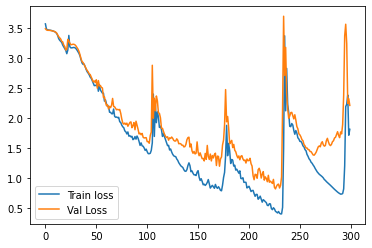

In [29]:
plt.plot(history_1.history['loss'], label='Train loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.legend();

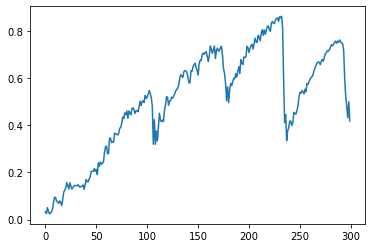

In [64]:
plt.plot(history_1.history['categorical_accuracy'], label='Train accuracy')


In [65]:
y1_pred = model_1.predict(X_test) 
ytrue = np.argmax(y_test, axis=1).tolist()
y1_pred = np.argmax(y1_pred, axis=1).tolist()

In [66]:
accuracy_score(ytrue, y1_pred)

0.0

### Model #2
added an extra LSTM layer and dense layer

In [35]:
model_2 = Sequential() #instantiate model 
model_2.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(30,258))) # input layer, each video is 30 frames w 258 keypts
model_2.add(LSTM(128, return_sequences=True, activation='relu'))
model_2.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so return_seq needs to be FALSE
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(all_actions.shape[0], activation='softmax'))


In [36]:
model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [42]:
history_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=len(X_train), callbacks=[tb_callback])

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 3.4690 - categorical_accuracy: 0.0324 - val_loss: 3.4634 - val_categorical_accuracy: 0.0312
Epoch 2/300
1/1 [==============================] - 1s 850ms/step - loss: 3.4645 - categorical_accuracy: 0.0347 - val_loss: 3.4660 - val_categorical_accuracy: 0.0729
Epoch 3/300
1/1 [==============================] - 1s 859ms/step - loss: 3.4626 - categorical_accuracy: 0.0556 - val_loss: 3.4671 - val_categorical_accuracy: 0.0104
Epoch 4/300
1/1 [==============================] - 1s 1s/step - loss: 3.4602 - categorical_accuracy: 0.0336 - val_loss: 3.4673 - val_categorical_accuracy: 0.0104
Epoch 5/300
1/1 [==============================] - 1s 1s/step - loss: 3.4579 - categorical_accuracy: 0.0336 - val_loss: 3.4666 - val_categorical_accuracy: 0.0104
Epoch 6/300
1/1 [==============================] - 1s 837ms/step - loss: 3.4544 - categorical_accuracy: 0.0336 - val_loss: 3.4655 - val_categorical_accuracy: 0.0104
Epoch 7/300
1/1 [==

Epoch 51/300
1/1 [==============================] - 1s 973ms/step - loss: 2.5391 - categorical_accuracy: 0.2396 - val_loss: 2.6274 - val_categorical_accuracy: 0.1979
Epoch 52/300
1/1 [==============================] - 1s 1s/step - loss: 2.5165 - categorical_accuracy: 0.2407 - val_loss: 2.5180 - val_categorical_accuracy: 0.2188
Epoch 53/300
1/1 [==============================] - 1s 1s/step - loss: 2.4213 - categorical_accuracy: 0.2720 - val_loss: 2.5740 - val_categorical_accuracy: 0.1979
Epoch 54/300
1/1 [==============================] - 1s 891ms/step - loss: 2.5066 - categorical_accuracy: 0.2604 - val_loss: 2.5670 - val_categorical_accuracy: 0.1771
Epoch 55/300
1/1 [==============================] - 1s 1s/step - loss: 2.5218 - categorical_accuracy: 0.2292 - val_loss: 2.5191 - val_categorical_accuracy: 0.1979
Epoch 56/300
1/1 [==============================] - 1s 1s/step - loss: 2.3780 - categorical_accuracy: 0.2569 - val_loss: 2.5408 - val_categorical_accuracy: 0.2188
Epoch 57/300
1/1

1/1 [==============================] - 1s 781ms/step - loss: 2.0796 - categorical_accuracy: 0.3391 - val_loss: 2.2781 - val_categorical_accuracy: 0.2604
Epoch 101/300
1/1 [==============================] - 1s 794ms/step - loss: 2.1599 - categorical_accuracy: 0.2986 - val_loss: 2.1703 - val_categorical_accuracy: 0.2708
Epoch 102/300
1/1 [==============================] - 1s 795ms/step - loss: 2.0527 - categorical_accuracy: 0.3368 - val_loss: 2.1138 - val_categorical_accuracy: 0.3229
Epoch 103/300
1/1 [==============================] - 1s 941ms/step - loss: 1.9891 - categorical_accuracy: 0.3391 - val_loss: 2.1495 - val_categorical_accuracy: 0.3333
Epoch 104/300
1/1 [==============================] - 1s 963ms/step - loss: 2.0249 - categorical_accuracy: 0.3310 - val_loss: 2.0717 - val_categorical_accuracy: 0.3333
Epoch 105/300
1/1 [==============================] - 1s 987ms/step - loss: 1.9502 - categorical_accuracy: 0.3762 - val_loss: 2.0574 - val_categorical_accuracy: 0.3229
Epoch 106/30

1/1 [==============================] - 1s 960ms/step - loss: 1.4361 - categorical_accuracy: 0.4988 - val_loss: 1.9200 - val_categorical_accuracy: 0.4167
Epoch 150/300
1/1 [==============================] - 1s 929ms/step - loss: 1.4322 - categorical_accuracy: 0.5116 - val_loss: 1.6976 - val_categorical_accuracy: 0.5417
Epoch 151/300
1/1 [==============================] - 1s 843ms/step - loss: 1.3356 - categorical_accuracy: 0.5544 - val_loss: 1.7505 - val_categorical_accuracy: 0.4688
Epoch 152/300
1/1 [==============================] - 1s 873ms/step - loss: 1.3632 - categorical_accuracy: 0.5509 - val_loss: 1.7818 - val_categorical_accuracy: 0.4375
Epoch 153/300
1/1 [==============================] - 1s 1s/step - loss: 1.3309 - categorical_accuracy: 0.5544 - val_loss: 1.6101 - val_categorical_accuracy: 0.5312
Epoch 154/300
1/1 [==============================] - 1s 1s/step - loss: 1.2921 - categorical_accuracy: 0.5729 - val_loss: 1.6712 - val_categorical_accuracy: 0.5000
Epoch 155/300
1/1 

1/1 [==============================] - 1s 1s/step - loss: 0.9814 - categorical_accuracy: 0.6562 - val_loss: 1.7670 - val_categorical_accuracy: 0.5312
Epoch 199/300
1/1 [==============================] - 1s 1s/step - loss: 1.0531 - categorical_accuracy: 0.6424 - val_loss: 1.6414 - val_categorical_accuracy: 0.4792
Epoch 200/300
1/1 [==============================] - 1s 1s/step - loss: 1.0698 - categorical_accuracy: 0.6169 - val_loss: 1.9290 - val_categorical_accuracy: 0.4479
Epoch 201/300
1/1 [==============================] - 1s 1s/step - loss: 1.1593 - categorical_accuracy: 0.6076 - val_loss: 1.6253 - val_categorical_accuracy: 0.5000
Epoch 202/300
1/1 [==============================] - 1s 982ms/step - loss: 1.0366 - categorical_accuracy: 0.6412 - val_loss: 1.6194 - val_categorical_accuracy: 0.5104
Epoch 203/300
1/1 [==============================] - 1s 1s/step - loss: 0.9807 - categorical_accuracy: 0.6748 - val_loss: 1.7154 - val_categorical_accuracy: 0.4896
Epoch 204/300
1/1 [========

1/1 [==============================] - 1s 1s/step - loss: 0.5828 - categorical_accuracy: 0.7975 - val_loss: 1.3727 - val_categorical_accuracy: 0.5833
Epoch 248/300
1/1 [==============================] - 1s 897ms/step - loss: 0.5830 - categorical_accuracy: 0.7963 - val_loss: 1.3184 - val_categorical_accuracy: 0.6458
Epoch 249/300
1/1 [==============================] - 1s 1s/step - loss: 0.5856 - categorical_accuracy: 0.7963 - val_loss: 1.3945 - val_categorical_accuracy: 0.6250
Epoch 250/300
1/1 [==============================] - 1s 873ms/step - loss: 0.5670 - categorical_accuracy: 0.8044 - val_loss: 1.3222 - val_categorical_accuracy: 0.6146
Epoch 251/300
1/1 [==============================] - 1s 984ms/step - loss: 0.5136 - categorical_accuracy: 0.8275 - val_loss: 1.2941 - val_categorical_accuracy: 0.6458
Epoch 252/300
1/1 [==============================] - 1s 905ms/step - loss: 0.5136 - categorical_accuracy: 0.8206 - val_loss: 1.4531 - val_categorical_accuracy: 0.6042
Epoch 253/300
1/1 

1/1 [==============================] - 1s 814ms/step - loss: 1.5089 - categorical_accuracy: 0.4861 - val_loss: 2.1013 - val_categorical_accuracy: 0.3438
Epoch 297/300
1/1 [==============================] - 1s 788ms/step - loss: 1.6537 - categorical_accuracy: 0.4850 - val_loss: 2.1468 - val_categorical_accuracy: 0.3021
Epoch 298/300
1/1 [==============================] - 1s 782ms/step - loss: 2.0117 - categorical_accuracy: 0.4005 - val_loss: 2.0798 - val_categorical_accuracy: 0.3125
Epoch 299/300
1/1 [==============================] - 1s 768ms/step - loss: 1.9833 - categorical_accuracy: 0.3808 - val_loss: 2.0126 - val_categorical_accuracy: 0.2917
Epoch 300/300
1/1 [==============================] - 1s 760ms/step - loss: 1.9184 - categorical_accuracy: 0.3935 - val_loss: 2.0523 - val_categorical_accuracy: 0.2812


In [43]:
train_acc = model_2.evaluate(X_train, y_train) 
test_acc = model_2.evaluate(X_test, y_test)  
print(f'Train score {train_acc}, Test score {test_acc}')

3/3 [==============================] - 0s 29ms/step - loss: 2.0523 - categorical_accuracy: 0.2812
Train score [1.88243567943573, 0.3784722089767456], Test score [2.0522541999816895, 0.28125]


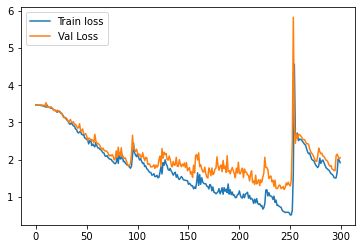

In [67]:
plt.plot(history_2.history['loss'], label='Train loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.legend();

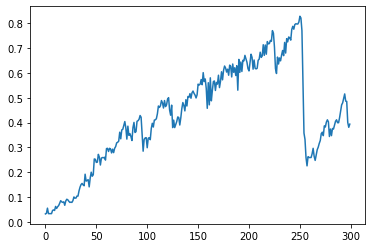

In [44]:
plt.plot(history_2.history['categorical_accuracy'], label='Train accuracy')


In [68]:
y2_pred = model_2.predict(X_test) 
ytrue = np.argmax(y_test, axis=1).tolist()
y2_pred = np.argmax(y2_pred, axis=1).tolist()

In [69]:
accuracy_score(ytrue, y2_pred)

0.28125

### Model #3 
- increased number of neurons in input layer from 50 to 64

In [45]:
model_3 = Sequential()
model_3.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video is 30 frames w 258 keypts
model_3.add(LSTM(128, return_sequences=True, activation='relu'))
model_3.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so return_seq needs to be FALSE
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(all_actions.shape[0], activation='softmax'))


In [46]:
model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [47]:
history_3 = model_3.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=len(X_train), callbacks=[tb_callback])

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 3.4675 - categorical_accuracy: 0.0370 - val_loss: 3.4658 - val_categorical_accuracy: 0.0208
Epoch 2/300
1/1 [==============================] - 2s 2s/step - loss: 3.4651 - categorical_accuracy: 0.0324 - val_loss: 3.4640 - val_categorical_accuracy: 0.0312
Epoch 3/300
1/1 [==============================] - 2s 2s/step - loss: 3.4612 - categorical_accuracy: 0.0359 - val_loss: 3.4617 - val_categorical_accuracy: 0.0208
Epoch 4/300
1/1 [==============================] - 2s 2s/step - loss: 3.4583 - categorical_accuracy: 0.0336 - val_loss: 3.4558 - val_categorical_accuracy: 0.0208
Epoch 5/300
1/1 [==============================] - 2s 2s/step - loss: 3.4513 - categorical_accuracy: 0.0336 - val_loss: 3.4494 - val_categorical_accuracy: 0.0208
Epoch 6/300
1/1 [==============================] - 1s 1s/step - loss: 3.4406 - categorical_accuracy: 0.0347 - val_loss: 3.4360 - val_categorical_accuracy: 0.0208
Epoch 7/300
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 2.5941 - categorical_accuracy: 0.2002 - val_loss: 2.6965 - val_categorical_accuracy: 0.1667
Epoch 52/300
1/1 [==============================] - 1s 1s/step - loss: 2.5812 - categorical_accuracy: 0.2072 - val_loss: 2.6764 - val_categorical_accuracy: 0.1771
Epoch 53/300
1/1 [==============================] - 1s 1s/step - loss: 2.5640 - categorical_accuracy: 0.2141 - val_loss: 2.6394 - val_categorical_accuracy: 0.1875
Epoch 54/300
1/1 [==============================] - 1s 1s/step - loss: 2.5341 - categorical_accuracy: 0.2303 - val_loss: 2.6036 - val_categorical_accuracy: 0.1875
Epoch 55/300
1/1 [==============================] - 1s 1s/step - loss: 2.4914 - categorical_accuracy: 0.2280 - val_loss: 2.5754 - val_categorical_accuracy: 0.1875
Epoch 56/300
1/1 [==============================] - 1s 890ms/step - loss: 2.4601 - categorical_accuracy: 0.2338 - val_loss: 2.5876 - val_categorical_accuracy: 0.1875
Epoch 57/300
1/1 [==============

Epoch 101/300
1/1 [==============================] - 1s 912ms/step - loss: 2.0651 - categorical_accuracy: 0.3056 - val_loss: 2.1653 - val_categorical_accuracy: 0.2604
Epoch 102/300
1/1 [==============================] - 1s 908ms/step - loss: 2.0145 - categorical_accuracy: 0.3426 - val_loss: 2.1024 - val_categorical_accuracy: 0.2396
Epoch 103/300
1/1 [==============================] - 1s 844ms/step - loss: 1.9560 - categorical_accuracy: 0.3611 - val_loss: 2.1165 - val_categorical_accuracy: 0.2292
Epoch 104/300
1/1 [==============================] - 1s 859ms/step - loss: 1.9562 - categorical_accuracy: 0.3461 - val_loss: 2.0942 - val_categorical_accuracy: 0.2500
Epoch 105/300
1/1 [==============================] - 1s 920ms/step - loss: 1.8960 - categorical_accuracy: 0.3877 - val_loss: 2.0509 - val_categorical_accuracy: 0.2708
Epoch 106/300
1/1 [==============================] - 1s 990ms/step - loss: 1.8326 - categorical_accuracy: 0.3970 - val_loss: 2.0297 - val_categorical_accuracy: 0.270

1/1 [==============================] - 1s 886ms/step - loss: 1.7953 - categorical_accuracy: 0.4178 - val_loss: 1.9054 - val_categorical_accuracy: 0.3125
Epoch 151/300
1/1 [==============================] - 1s 1s/step - loss: 1.7749 - categorical_accuracy: 0.3935 - val_loss: 1.9916 - val_categorical_accuracy: 0.3125
Epoch 152/300
1/1 [==============================] - 1s 1s/step - loss: 1.6903 - categorical_accuracy: 0.4340 - val_loss: 1.9537 - val_categorical_accuracy: 0.3646
Epoch 153/300
1/1 [==============================] - 1s 1s/step - loss: 1.6637 - categorical_accuracy: 0.4456 - val_loss: 1.9145 - val_categorical_accuracy: 0.3750
Epoch 154/300
1/1 [==============================] - 1s 1s/step - loss: 1.6495 - categorical_accuracy: 0.4549 - val_loss: 2.3335 - val_categorical_accuracy: 0.4167
Epoch 155/300
1/1 [==============================] - 1s 914ms/step - loss: 2.2921 - categorical_accuracy: 0.4410 - val_loss: 5.5270 - val_categorical_accuracy: 0.1667
Epoch 156/300
1/1 [=====

Epoch 200/300
1/1 [==============================] - 1s 1s/step - loss: 2.1712 - categorical_accuracy: 0.3032 - val_loss: 2.3322 - val_categorical_accuracy: 0.2396
Epoch 201/300
1/1 [==============================] - 2s 2s/step - loss: 2.1765 - categorical_accuracy: 0.3218 - val_loss: 2.3858 - val_categorical_accuracy: 0.2500
Epoch 202/300
1/1 [==============================] - 1s 1s/step - loss: 2.2547 - categorical_accuracy: 0.2870 - val_loss: 2.3795 - val_categorical_accuracy: 0.1771
Epoch 203/300
1/1 [==============================] - 1s 982ms/step - loss: 2.2524 - categorical_accuracy: 0.2801 - val_loss: 2.3167 - val_categorical_accuracy: 0.2292
Epoch 204/300
1/1 [==============================] - 1s 898ms/step - loss: 2.1627 - categorical_accuracy: 0.3032 - val_loss: 2.2895 - val_categorical_accuracy: 0.2292
Epoch 205/300
1/1 [==============================] - 1s 902ms/step - loss: 2.1113 - categorical_accuracy: 0.3229 - val_loss: 2.3715 - val_categorical_accuracy: 0.2188
Epoch 2

1/1 [==============================] - 1s 831ms/step - loss: 1.9779 - categorical_accuracy: 0.3553 - val_loss: 2.1191 - val_categorical_accuracy: 0.2292
Epoch 250/300
1/1 [==============================] - 1s 834ms/step - loss: 1.9603 - categorical_accuracy: 0.3588 - val_loss: 2.1045 - val_categorical_accuracy: 0.2292
Epoch 251/300
1/1 [==============================] - 1s 814ms/step - loss: 1.9341 - categorical_accuracy: 0.3704 - val_loss: 2.0912 - val_categorical_accuracy: 0.2500
Epoch 252/300
1/1 [==============================] - 1s 818ms/step - loss: 1.9049 - categorical_accuracy: 0.3773 - val_loss: 2.0720 - val_categorical_accuracy: 0.2396
Epoch 253/300
1/1 [==============================] - 1s 803ms/step - loss: 1.8785 - categorical_accuracy: 0.3831 - val_loss: 2.0441 - val_categorical_accuracy: 0.2396
Epoch 254/300
1/1 [==============================] - 1s 833ms/step - loss: 1.8465 - categorical_accuracy: 0.3889 - val_loss: 2.0166 - val_categorical_accuracy: 0.2396
Epoch 255/30

1/1 [==============================] - 1s 801ms/step - loss: 1.4339 - categorical_accuracy: 0.5012 - val_loss: 1.7929 - val_categorical_accuracy: 0.4167
Epoch 299/300
1/1 [==============================] - 1s 983ms/step - loss: 1.4723 - categorical_accuracy: 0.5370 - val_loss: 1.6256 - val_categorical_accuracy: 0.4167
Epoch 300/300
1/1 [==============================] - 1s 811ms/step - loss: 1.4053 - categorical_accuracy: 0.5220 - val_loss: 1.8503 - val_categorical_accuracy: 0.3958


In [48]:
train_acc = model_3.evaluate(X_train, y_train) 
test_acc = model_3.evaluate(X_test, y_test)  
print(f'Train score {train_acc}, Test score {test_acc}')

3/3 [==============================] - 0s 30ms/step - loss: 1.8503 - categorical_accuracy: 0.3958
Train score [1.4458887577056885, 0.4895833432674408], Test score [1.85025155544281, 0.3958333432674408]


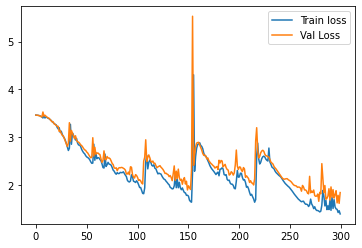

In [63]:
plt.plot(history_3.history['loss'], label='Train loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.legend();

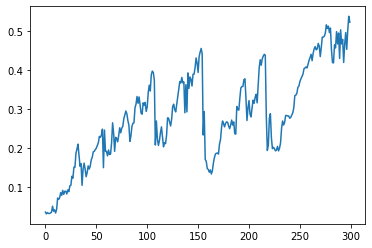

In [49]:
plt.plot(history_3.history['categorical_accuracy'], label='Train accuracy')

In [50]:
y3_pred = model_3.predict(X_test) 

In [51]:
ytrue = np.argmax(y_test, axis=1).tolist()
y3_pred = np.argmax(y3_pred, axis=1).tolist()

In [52]:
accuracy_score(ytrue, y3_pred)

0.3958333333333333

Accuracy score saw an increase to 0.39, we can attempt to increase the number of neurons in other layers again

### Model #4 
- increased number of neurons in the final dense layer

In [53]:
model_4 = Sequential()
model_4.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video is 30 frames w 258 keypts
model_4.add(LSTM(128, return_sequences=True, activation='relu'))
model_4.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so return_seq needs to be FALSE
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(all_actions.shape[0], activation='softmax'))

In [54]:
model_4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [55]:
history_4 = model_4.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=len(X_train), callbacks=[tb_callback])

Epoch 1/300
1/1 [==============================] - 5s 5s/step - loss: 3.4713 - categorical_accuracy: 0.0336 - val_loss: 3.4688 - val_categorical_accuracy: 0.0104
Epoch 2/300
1/1 [==============================] - 1s 1s/step - loss: 3.4636 - categorical_accuracy: 0.0324 - val_loss: 3.4671 - val_categorical_accuracy: 0.0208
Epoch 3/300
1/1 [==============================] - 1s 1s/step - loss: 3.4581 - categorical_accuracy: 0.0486 - val_loss: 3.4593 - val_categorical_accuracy: 0.0104
Epoch 4/300
1/1 [==============================] - 1s 1s/step - loss: 3.4467 - categorical_accuracy: 0.0370 - val_loss: 3.4513 - val_categorical_accuracy: 0.0104
Epoch 5/300
1/1 [==============================] - 1s 1s/step - loss: 3.4267 - categorical_accuracy: 0.0359 - val_loss: 3.4508 - val_categorical_accuracy: 0.0104
Epoch 6/300
1/1 [==============================] - 1s 1s/step - loss: 3.4011 - categorical_accuracy: 0.0336 - val_loss: 3.4332 - val_categorical_accuracy: 0.0104
Epoch 7/300
1/1 [===========

1/1 [==============================] - 1s 975ms/step - loss: 2.1841 - categorical_accuracy: 0.2512 - val_loss: 2.4533 - val_categorical_accuracy: 0.1979
Epoch 52/300
1/1 [==============================] - 1s 1s/step - loss: 2.1507 - categorical_accuracy: 0.2801 - val_loss: 2.4257 - val_categorical_accuracy: 0.2188
Epoch 53/300
1/1 [==============================] - 1s 1s/step - loss: 2.1624 - categorical_accuracy: 0.2870 - val_loss: 2.8025 - val_categorical_accuracy: 0.1875
Epoch 54/300
1/1 [==============================] - 1s 950ms/step - loss: 2.3323 - categorical_accuracy: 0.2454 - val_loss: 2.6105 - val_categorical_accuracy: 0.1562
Epoch 55/300
1/1 [==============================] - 1s 1s/step - loss: 2.3284 - categorical_accuracy: 0.2361 - val_loss: 2.5434 - val_categorical_accuracy: 0.2396
Epoch 56/300
1/1 [==============================] - 1s 911ms/step - loss: 2.2802 - categorical_accuracy: 0.2593 - val_loss: 2.5675 - val_categorical_accuracy: 0.1667
Epoch 57/300
1/1 [========

Epoch 101/300
1/1 [==============================] - 1s 1s/step - loss: 1.6304 - categorical_accuracy: 0.4537 - val_loss: 1.9800 - val_categorical_accuracy: 0.3542
Epoch 102/300
1/1 [==============================] - 1s 869ms/step - loss: 1.5703 - categorical_accuracy: 0.4780 - val_loss: 1.9399 - val_categorical_accuracy: 0.3542
Epoch 103/300
1/1 [==============================] - 1s 1s/step - loss: 1.6310 - categorical_accuracy: 0.4595 - val_loss: 1.9242 - val_categorical_accuracy: 0.3438
Epoch 104/300
1/1 [==============================] - 1s 914ms/step - loss: 1.4967 - categorical_accuracy: 0.4942 - val_loss: 1.9371 - val_categorical_accuracy: 0.3125
Epoch 105/300
1/1 [==============================] - 1s 984ms/step - loss: 1.5426 - categorical_accuracy: 0.4792 - val_loss: 1.7978 - val_categorical_accuracy: 0.3750
Epoch 106/300
1/1 [==============================] - 1s 938ms/step - loss: 1.5246 - categorical_accuracy: 0.5116 - val_loss: 1.7694 - val_categorical_accuracy: 0.4271
Epoc

1/1 [==============================] - 1s 803ms/step - loss: 1.1873 - categorical_accuracy: 0.5787 - val_loss: 1.7911 - val_categorical_accuracy: 0.3958
Epoch 151/300
1/1 [==============================] - 1s 941ms/step - loss: 1.2762 - categorical_accuracy: 0.5451 - val_loss: 1.7420 - val_categorical_accuracy: 0.4062
Epoch 152/300
1/1 [==============================] - 1s 1s/step - loss: 1.3019 - categorical_accuracy: 0.5613 - val_loss: 1.5998 - val_categorical_accuracy: 0.4062
Epoch 153/300
1/1 [==============================] - 1s 982ms/step - loss: 1.2525 - categorical_accuracy: 0.5764 - val_loss: 1.6122 - val_categorical_accuracy: 0.4375
Epoch 154/300
1/1 [==============================] - 1s 1s/step - loss: 1.2382 - categorical_accuracy: 0.5683 - val_loss: 1.6640 - val_categorical_accuracy: 0.4062
Epoch 155/300
1/1 [==============================] - 1s 1s/step - loss: 1.1878 - categorical_accuracy: 0.5787 - val_loss: 1.5947 - val_categorical_accuracy: 0.4688
Epoch 156/300
1/1 [==

Epoch 200/300
1/1 [==============================] - 1s 884ms/step - loss: 1.7283 - categorical_accuracy: 0.4213 - val_loss: 2.1497 - val_categorical_accuracy: 0.3125
Epoch 201/300
1/1 [==============================] - 1s 877ms/step - loss: 1.8102 - categorical_accuracy: 0.4132 - val_loss: 1.9696 - val_categorical_accuracy: 0.3438
Epoch 202/300
1/1 [==============================] - 1s 1s/step - loss: 1.5812 - categorical_accuracy: 0.4676 - val_loss: 1.8542 - val_categorical_accuracy: 0.4271
Epoch 203/300
1/1 [==============================] - 1s 996ms/step - loss: 1.5829 - categorical_accuracy: 0.4630 - val_loss: 2.0530 - val_categorical_accuracy: 0.3646
Epoch 204/300
1/1 [==============================] - 1s 969ms/step - loss: 1.6492 - categorical_accuracy: 0.4688 - val_loss: 1.7810 - val_categorical_accuracy: 0.3750
Epoch 205/300
1/1 [==============================] - 1s 1s/step - loss: 1.4796 - categorical_accuracy: 0.5104 - val_loss: 1.9279 - val_categorical_accuracy: 0.3021
Epoc

1/1 [==============================] - 1s 953ms/step - loss: 0.7769 - categorical_accuracy: 0.7407 - val_loss: 1.3120 - val_categorical_accuracy: 0.6042
Epoch 250/300
1/1 [==============================] - 1s 1s/step - loss: 0.7581 - categorical_accuracy: 0.7396 - val_loss: 1.2371 - val_categorical_accuracy: 0.6146
Epoch 251/300
1/1 [==============================] - 1s 1s/step - loss: 0.7478 - categorical_accuracy: 0.7512 - val_loss: 1.2741 - val_categorical_accuracy: 0.6042
Epoch 252/300
1/1 [==============================] - 1s 1s/step - loss: 0.7370 - categorical_accuracy: 0.7512 - val_loss: 1.3365 - val_categorical_accuracy: 0.6250
Epoch 253/300
1/1 [==============================] - 1s 985ms/step - loss: 0.7162 - categorical_accuracy: 0.7546 - val_loss: 1.1820 - val_categorical_accuracy: 0.6354
Epoch 254/300
1/1 [==============================] - 1s 964ms/step - loss: 0.7203 - categorical_accuracy: 0.7627 - val_loss: 1.2712 - val_categorical_accuracy: 0.5729
Epoch 255/300
1/1 [==

1/1 [==============================] - 1s 823ms/step - loss: 0.8391 - categorical_accuracy: 0.7118 - val_loss: 1.9699 - val_categorical_accuracy: 0.5312
Epoch 299/300
1/1 [==============================] - 1s 771ms/step - loss: 1.0912 - categorical_accuracy: 0.6400 - val_loss: 1.6876 - val_categorical_accuracy: 0.5000
Epoch 300/300
1/1 [==============================] - 1s 790ms/step - loss: 1.3629 - categorical_accuracy: 0.5718 - val_loss: 1.6986 - val_categorical_accuracy: 0.5521


In [56]:
train_acc = model_4.evaluate(X_train, y_train) 
test_acc = model_4.evaluate(X_test, y_test)  
print(f'Train score {train_acc}, Test score {test_acc}')

3/3 [==============================] - 0s 35ms/step - loss: 1.6986 - categorical_accuracy: 0.5521
Train score [1.3915863037109375, 0.5983796119689941], Test score [1.6986117362976074, 0.5520833134651184]


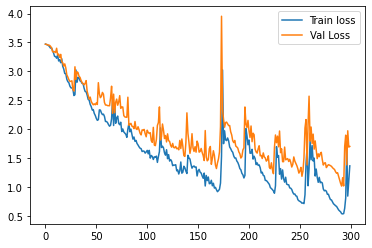

In [57]:
plt.plot(history_4.history['loss'], label='Train loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.legend();

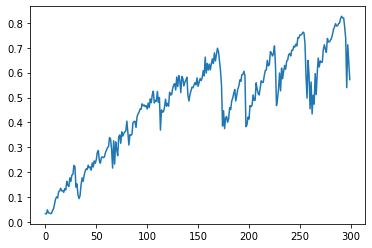

In [60]:
plt.plot(history_4.history['categorical_accuracy'], label='Train accuracy')

In [61]:
y4_pred = model_4.predict(X_test) 
ytrue = np.argmax(y_test, axis=1).tolist()
y4_pred = np.argmax(y4_pred, axis=1).tolist()

In [62]:
accuracy_score(ytrue, y4_pred)

0.5520833333333334

Accuracy score saw an increase to 0.55, however the train and test loss are starting to get wider, model may be starting to overfit. We should stop increasing the number of neurons in the layers and attempt other optimisation techniques

### Model #5 (Attempt Minibatch Gradient Descent)
- changed batch size to 32

In [70]:
model_5 = Sequential()
model_5.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video is 30 frames w 258 keypts
model_5.add(LSTM(128, return_sequences=True, activation='relu'))
model_5.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so return_seq needs to be FALSE
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(all_actions.shape[0], activation='softmax'))

In [71]:
model_5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [72]:
history_5 = model_5.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=32, callbacks=[tb_callback])

Epoch 1/300
27/27 [==============================] - 6s 88ms/step - loss: 3.4160 - categorical_accuracy: 0.0486 - val_loss: 3.3649 - val_categorical_accuracy: 0.0625
Epoch 2/300
27/27 [==============================] - 3s 95ms/step - loss: 3.3454 - categorical_accuracy: 0.0914 - val_loss: 3.4480 - val_categorical_accuracy: 0.0208
Epoch 3/300
27/27 [==============================] - 2s 70ms/step - loss: 3.2798 - categorical_accuracy: 0.0764 - val_loss: 3.1334 - val_categorical_accuracy: 0.0833
Epoch 4/300
27/27 [==============================] - 2s 72ms/step - loss: 2.9707 - categorical_accuracy: 0.0961 - val_loss: 3.0099 - val_categorical_accuracy: 0.0312
Epoch 5/300
27/27 [==============================] - 2s 86ms/step - loss: 2.7519 - categorical_accuracy: 0.1250 - val_loss: 2.7071 - val_categorical_accuracy: 0.0938
Epoch 6/300
27/27 [==============================] - 2s 69ms/step - loss: 2.5142 - categorical_accuracy: 0.1574 - val_loss: 2.5395 - val_categorical_accuracy: 0.1875
Epoc

27/27 [==============================] - 2s 93ms/step - loss: 2.9409 - categorical_accuracy: 0.1146 - val_loss: 2.9197 - val_categorical_accuracy: 0.0833
Epoch 51/300
27/27 [==============================] - 2s 79ms/step - loss: 2.7552 - categorical_accuracy: 0.1562 - val_loss: 2.8459 - val_categorical_accuracy: 0.0729
Epoch 52/300
27/27 [==============================] - 2s 74ms/step - loss: 2.6450 - categorical_accuracy: 0.1609 - val_loss: 2.8307 - val_categorical_accuracy: 0.0833
Epoch 53/300
27/27 [==============================] - 2s 78ms/step - loss: 2.5557 - categorical_accuracy: 0.1898 - val_loss: 2.6591 - val_categorical_accuracy: 0.1354
Epoch 54/300
27/27 [==============================] - 2s 63ms/step - loss: 2.3987 - categorical_accuracy: 0.1898 - val_loss: 2.4197 - val_categorical_accuracy: 0.2396
Epoch 55/300
27/27 [==============================] - 2s 69ms/step - loss: 2.3224 - categorical_accuracy: 0.2338 - val_loss: 2.4446 - val_categorical_accuracy: 0.1771
Epoch 56/30

27/27 [==============================] - 2s 80ms/step - loss: 0.9081 - categorical_accuracy: 0.6597 - val_loss: 1.3880 - val_categorical_accuracy: 0.4688
Epoch 100/300
27/27 [==============================] - 2s 82ms/step - loss: 1.0910 - categorical_accuracy: 0.6065 - val_loss: 1.5753 - val_categorical_accuracy: 0.3750
Epoch 101/300
27/27 [==============================] - 2s 68ms/step - loss: 0.9616 - categorical_accuracy: 0.6389 - val_loss: 1.0125 - val_categorical_accuracy: 0.6875
Epoch 102/300
27/27 [==============================] - 2s 73ms/step - loss: 0.7942 - categorical_accuracy: 0.6921 - val_loss: 1.1507 - val_categorical_accuracy: 0.5208
Epoch 103/300
27/27 [==============================] - 2s 73ms/step - loss: 0.9239 - categorical_accuracy: 0.6551 - val_loss: 1.1418 - val_categorical_accuracy: 0.6250
Epoch 104/300
27/27 [==============================] - 2s 63ms/step - loss: 0.9913 - categorical_accuracy: 0.6435 - val_loss: 1.1509 - val_categorical_accuracy: 0.5312
Epoch 

Epoch 148/300
27/27 [==============================] - 2s 69ms/step - loss: 0.2973 - categorical_accuracy: 0.8958 - val_loss: 0.8259 - val_categorical_accuracy: 0.7083
Epoch 149/300
27/27 [==============================] - 2s 70ms/step - loss: 0.3184 - categorical_accuracy: 0.8912 - val_loss: 0.7576 - val_categorical_accuracy: 0.7604
Epoch 150/300
27/27 [==============================] - 2s 70ms/step - loss: 0.3610 - categorical_accuracy: 0.8611 - val_loss: 0.6834 - val_categorical_accuracy: 0.7500
Epoch 151/300
27/27 [==============================] - 2s 88ms/step - loss: 0.3032 - categorical_accuracy: 0.8866 - val_loss: 0.9573 - val_categorical_accuracy: 0.6458
Epoch 152/300
27/27 [==============================] - 2s 86ms/step - loss: 0.3381 - categorical_accuracy: 0.8738 - val_loss: 0.7058 - val_categorical_accuracy: 0.7500
Epoch 153/300
27/27 [==============================] - 2s 61ms/step - loss: 0.3757 - categorical_accuracy: 0.8576 - val_loss: 0.9993 - val_categorical_accuracy:

Epoch 197/300
27/27 [==============================] - 2s 57ms/step - loss: 0.1946 - categorical_accuracy: 0.9248 - val_loss: 0.7154 - val_categorical_accuracy: 0.7812
Epoch 198/300
27/27 [==============================] - 2s 58ms/step - loss: 0.1352 - categorical_accuracy: 0.9583 - val_loss: 0.7657 - val_categorical_accuracy: 0.7708
Epoch 199/300
27/27 [==============================] - 2s 57ms/step - loss: 0.1653 - categorical_accuracy: 0.9329 - val_loss: 0.5509 - val_categorical_accuracy: 0.7917
Epoch 200/300
27/27 [==============================] - 2s 59ms/step - loss: 0.1378 - categorical_accuracy: 0.9537 - val_loss: 0.7084 - val_categorical_accuracy: 0.7917
Epoch 201/300
27/27 [==============================] - 2s 58ms/step - loss: 0.2302 - categorical_accuracy: 0.9155 - val_loss: 0.8062 - val_categorical_accuracy: 0.7812
Epoch 202/300
27/27 [==============================] - 2s 57ms/step - loss: 0.4444 - categorical_accuracy: 0.8414 - val_loss: 0.8524 - val_categorical_accuracy:

Epoch 246/300
27/27 [==============================] - 2s 58ms/step - loss: 0.1308 - categorical_accuracy: 0.9595 - val_loss: 0.5398 - val_categorical_accuracy: 0.8021
Epoch 247/300
27/27 [==============================] - 2s 58ms/step - loss: 0.0582 - categorical_accuracy: 0.9838 - val_loss: 0.6219 - val_categorical_accuracy: 0.8125
Epoch 248/300
27/27 [==============================] - 2s 56ms/step - loss: 0.0689 - categorical_accuracy: 0.9780 - val_loss: 0.5473 - val_categorical_accuracy: 0.8229
Epoch 249/300
27/27 [==============================] - 2s 61ms/step - loss: 0.0735 - categorical_accuracy: 0.9769 - val_loss: 0.5556 - val_categorical_accuracy: 0.8542
Epoch 250/300
27/27 [==============================] - 2s 57ms/step - loss: 0.0880 - categorical_accuracy: 0.9676 - val_loss: 0.8202 - val_categorical_accuracy: 0.7812
Epoch 251/300
27/27 [==============================] - 2s 57ms/step - loss: 0.0784 - categorical_accuracy: 0.9722 - val_loss: 0.7663 - val_categorical_accuracy:

Epoch 295/300
27/27 [==============================] - 2s 60ms/step - loss: 0.2314 - categorical_accuracy: 0.9155 - val_loss: 1.0923 - val_categorical_accuracy: 0.7188
Epoch 296/300
27/27 [==============================] - 2s 58ms/step - loss: 0.1687 - categorical_accuracy: 0.9375 - val_loss: 0.7784 - val_categorical_accuracy: 0.7396
Epoch 297/300
27/27 [==============================] - 2s 57ms/step - loss: 0.1523 - categorical_accuracy: 0.9433 - val_loss: 1.4941 - val_categorical_accuracy: 0.6562
Epoch 298/300
27/27 [==============================] - 2s 57ms/step - loss: 0.1718 - categorical_accuracy: 0.9514 - val_loss: 0.5398 - val_categorical_accuracy: 0.8646
Epoch 299/300
27/27 [==============================] - 2s 58ms/step - loss: 0.0472 - categorical_accuracy: 0.9907 - val_loss: 0.6180 - val_categorical_accuracy: 0.8542
Epoch 300/300
27/27 [==============================] - 2s 57ms/step - loss: 0.0407 - categorical_accuracy: 0.9850 - val_loss: 0.6075 - val_categorical_accuracy:

In [73]:
train_acc = model_5.evaluate(X_train, y_train) 
test_acc = model_5.evaluate(X_test, y_test)  
print(f'Train score {train_acc}, Test score {test_acc}')

3/3 [==============================] - 0s 46ms/step - loss: 0.6075 - categorical_accuracy: 0.8333
Train score [0.025560198351740837, 0.9953703880310059], Test score [0.607476532459259, 0.8333333134651184]


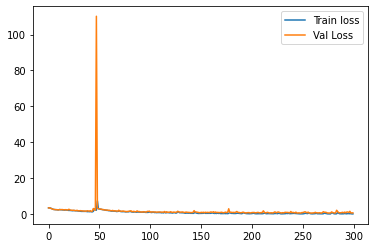

In [75]:
plt.plot(history_5.history['loss'], label='Train loss')
plt.plot(history_5.history['val_loss'], label='Val Loss')
plt.legend();

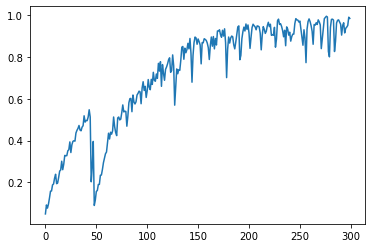

In [74]:
plt.plot(history_5.history['categorical_accuracy'], label='Train accuracy')

In [77]:
y5_pred = model_5.predict(X_test) 
ytrue = np.argmax(y_test, axis=1).tolist()
y5_pred = np.argmax(y5_pred, axis=1).tolist()

In [78]:
accuracy_score(ytrue, y5_pred)

0.8333333333333334

changing to minibatch gradient descent increased our accuracy score dramatically, so model #5 will  be our final model. <br />

### Save weights for model

In [80]:
model_5.save('sgsl_model_5')

2021-12-14 13:31:53.693693: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: sgsl_model_5/assets


In [90]:
model5_json = model_5.to_json()
with open("model5.json", "w") as json_file:
    json_file.write(model5_json)

In [ ]:
#to load model:
# model.load_weights('action.h5')

### Real-time Prediction

In [99]:
sequence = []
sentence = []
predictions = [] 
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        #cv2.startWindowThread()       
        
        # Read Feed
        ret, frame = cap.read() #reads in BGR format 

        # Make Detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        styled_landmarks(image, results)

        #prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model_5.predict(np.expand_dims(sequence, axis=0))[0]
            print(all_actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        # visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if all_actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(all_actions[np.argmax(res)])
                    else:
                            sentence.append(all_actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
        
            #image = prob_viz(res, greeting_actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show on screen
        cv2.imshow('Feed from OpenCV', image)

        #break using 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    #    Flip the image horizontally for a selfie-view display. [OPTIONAL, FOR TEST]
    #    cv2.imshow('MediaPipe Holistic', cv2.flip(image, 1))
    #    if cv2.waitKey(5) & 0xFF == 27:

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
w
<class 'mediapipe.python.solution_base.SolutionOutputs'>
w
<class 'mediapipe.python.solution_base.SolutionOutputs'>
w
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
w
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>
n
<class 'mediapipe.python.solution_base.SolutionOutputs'>

## Conclusion
The final model performance was a big improvement from the baseline model with an accuracy of 0.83. The model also performed relatively well during the real-time prediction. 

Although it should be noted that even though the model performed well in the modelling stage, the deployment of the model for real-time prediction requires additional factors. Some of the factors that would affect prediction are:
- lighting: 
In areas with insufficient or uneven lighting, the keypoint detection on the user's body would not be stable, hence good and even lighting is important.
- color and type of clothing: 
It had been observed during some trials that if the color of clothing was close to the user's skin tone and if the user wore long baggy sleeves, the keypoint detection on the user's body would be unstable as well 
- similar actions:
certain sign language signs appear similar to each other, which could result in wrong predictions sometimes. To counter this, during data collection, the differentiating movement or sign was done slower so that more sequences will be captured on the unique movements/actions. 



## Further Recommendations
The project can be expanded to include more signs than just the basic alphabets and greetings that it is currently trained on. Furthermore, a reverse function in the translation can also be added such that people could type in words and the relevant signs will appear on the screen.